# Import the necessary libraries

In [51]:
import gc
import os
import cv2 
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler


import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet152 # for feature extraction
from torch.utils.data import DataLoader # for batching data
from torch.utils.data import TensorDataset 
from torchvision.transforms import transforms 

warnings.filterwarnings('ignore')

# Load the Feature Extractor

In [ ]:
Deep_features = []
root = 'C:\\Users\\Eurus\\Desktop\\Data\\images'
device = torch.device('cuda')

# Load the ResNet-152 model
resnet = resnet152(pretrained=False)

In [ ]:
resnet.to(device)
resnet.eval()

# Prepare the Data

In [ ]:
# Transformation for preprocessing
preprocess = transforms.Compose([
    transforms.Resize((540, 540)),
    transforms.ToTensor()
])

In [ ]:
def feature_extractor(root):
    # Iterate over the images
    for idx in tqdm(os.listdir(root)):
        
        # Read the image
        path = os.path.join(root, idx)
        img = Image.open(path)
        
        # Preprocess the images (Normalize-> add a dummy dimention -> move it to cuda)
        img_tensor = preprocess(img).div(255.0).unsqueeze(0).to(device)
        
        # Extract features using ResNet-152
        with torch.no_grad():
            features = resnet(img_tensor)
            
        # Flatten the features
        features = features.flatten().cpu().numpy()
        
        # Store the features in the dictionary
        if "T" in idx:
            Deep_features.append({'Label':'T','Features':features})
        elif "N" in idx:
            Deep_features.append({'Label':'N','Features':features})
        else:
            print("error!")
            
    
    return Deep_features
        

In [ ]:
Train_features = feature_extractor(root)

In [ ]:
# shuffle the data
random.shuffle(Train_features)

In [ ]:
"Cleaning feature titles to make the dataset easy to use"

df = pd.DataFrame()

# Iterate over the list of dictionaries
for idx, d in enumerate(Train_features):
    # Extract the label and features from each dictionary
    label = d['Label']
    features = d['Features']
    
    # Create a dictionary for the row data
    row_data = {'Label': label}
    
    # Add the features as columns to the row dictionary
    for i, value in enumerate(features):
        column_name = f'F_{i}'
        row_data[column_name] = value
    
    # Append the row to the DataFrame
    df = df.append(row_data, ignore_index=True)

    
# Now we have df, Delete the residual
del Train_features

# Observe the results
df.head(5)

In [ ]:
"Encoding the Labels"

for row in tqdm(range(len(df))):
    if df.loc[row,'Label'] == "N":
        df.loc[row,'Label'] = 0
        
    elif df.loc[row,'Label'] == "T":
        df.loc[row,'Label'] = 1

# Convert them all to float32        
df = df.astype('float32')
df.info()        

In [ ]:
# Beware !!!
df.to_csv("df_output_cell_10.csv",index=False)

In [42]:
df = pd.read_csv("df_output_cell_10.csv")
df.head()

,Label,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_990,F_991,F_992,F_993,F_994,F_995,F_996,F_997,F_998,F_999
0,0.0,-3155.3340,2247.9016,-15242.063,2105.8013,4712.2056,26482.980,29321.460,22290.460,12380.1455,...,24386.512,-22758.016,32603.027,-22886.885,22423.560,-25667.980,7625.3670,9067.743,13116.528,300.804350
1,0.0,-4456.2400,5013.8184,-19840.195,3260.8843,5470.0503,33030.970,37948.010,27413.734,15669.2110,...,31678.412,-29751.850,42726.203,-28719.370,28016.207,-33457.973,11405.8260,12074.846,16793.018,76.287735
2,1.0,-3624.0283,4096.3154,-17587.424,2470.3438,5148.6680,28676.377,33115.723,23879.389,13839.6810,...,27025.328,-26016.256,36537.504,-24437.940,24452.035,-28386.310,9967.6120,10893.868,14938.218,215.583150
3,0.0,-4195.8760,4789.3535,-18938.963,2818.3047,5316.8325,31045.184,36170.170,26332.742,15174.0280,...,29719.297,-28442.473,40481.420,-27291.717,26547.879,-31284.033,10983.9375,11585.030,15812.540,209.395650
4,0.0,-5584.1300,6379.3710,-23731.717,3972.9082,6766.4370,39294.560,46416.805,32344.842,18326.2460,...,38469.840,-36466.477,51717.152,-34935.880,33479.850,-41357.324,14098.4250,13870.688,19981.975,21.897598


In [65]:
df

,Label,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_990,F_991,F_992,F_993,F_994,F_995,F_996,F_997,F_998,F_999
0,0.0,-3155.3340,2247.9016,-15242.0630,2105.8013,4712.2056,26482.980,29321.460,22290.460,12380.1455,...,24386.512,-22758.016,32603.027,-22886.885,22423.560,-25667.980,7625.3670,9067.743,13116.528,300.804350
1,0.0,-4456.2400,5013.8184,-19840.1950,3260.8843,5470.0503,33030.970,37948.010,27413.734,15669.2110,...,31678.412,-29751.850,42726.203,-28719.370,28016.207,-33457.973,11405.8260,12074.846,16793.018,76.287735
2,1.0,-3624.0283,4096.3154,-17587.4240,2470.3438,5148.6680,28676.377,33115.723,23879.389,13839.6810,...,27025.328,-26016.256,36537.504,-24437.940,24452.035,-28386.310,9967.6120,10893.868,14938.218,215.583150
3,0.0,-4195.8760,4789.3535,-18938.9630,2818.3047,5316.8325,31045.184,36170.170,26332.742,15174.0280,...,29719.297,-28442.473,40481.420,-27291.717,26547.879,-31284.033,10983.9375,11585.030,15812.540,209.395650
4,0.0,-5584.1300,6379.3710,-23731.7170,3972.9082,6766.4370,39294.560,46416.805,32344.842,18326.2460,...,38469.840,-36466.477,51717.152,-34935.880,33479.850,-41357.324,14098.4250,13870.688,19981.975,21.897598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13827,0.0,-4129.4795,4391.3700,-19488.6860,3261.3506,5897.7793,32177.951,37339.980,26856.924,15160.8990,...,30879.049,-29152.107,41523.957,-27680.812,27372.916,-32141.232,11123.6630,11852.786,16557.586,-299.656600
13828,0.0,-4177.4590,5608.9070,-18066.5490,3903.9004,5051.5670,30282.535,35785.215,25472.094,14094.4880,...,29602.312,-27842.770,39770.395,-26490.848,26038.742,-31476.930,10937.5500,10782.714,15268.558,241.861470
13829,0.0,-5443.9620,5232.1143,-21480.0250,2271.8105,6267.1030,34512.973,41261.777,29064.844,16938.2950,...,33816.594,-32461.523,45143.690,-30913.676,29712.146,-35876.860,13141.7910,12362.747,17797.680,134.881480
13830,0.0,-2498.8800,3960.5205,-16241.3125,3361.4053,5045.3080,26579.756,31003.297,21950.890,12483.2360,...,24814.617,-24305.352,34671.668,-22652.521,22957.684,-26322.457,9460.7630,10981.944,13899.124,-187.224960


# Beware ! Error Zone

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[21], line 18
     15 optimizer.zero_grad()
     17 # Forward Pass
---> 18 outputs = model(inputs)
     19 loss = criterion(outputs.squeeze(), labels)
     21 # Backpropagate

File ~\Desktop\YoloV8\Pytorch\lib\site-packages\torch\nn\modules\module.py:1501, in Module._call_impl(self, *args, **kwargs)
   1496 # If we don't have any hooks, we want to skip the rest of the logic in
   1497 # this function, and just call forward.
   1498 if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks or self._forward_pre_hooks
   1499         or _global_backward_pre_hooks or _global_backward_hooks
   1500         or _global_forward_hooks or _global_forward_pre_hooks):
-> 1501     return forward_call(*args, **kwargs)
   1502 # Do not call functions when jit is used
   1503 full_backward_hooks, non_full_backward_hooks = [], []

Cell In[16], line 98, in TabularTransformer.forward(self, x, memory)
     95 embedded = self.embedding(x)
     97 print(f" This is embeded before long:\n {embedded}")
---> 98 embedded = self.embedding.weight[embedded.long(), :].to_dense()
     99 print(f" This is embeded after long:\n {embedded}")
    100 embedded = embedded.permute(2, 0, 1)       

IndexError: index -18739 is out of bounds for dimension 0 with size 128

#### We must use scalers to rescale the data so it fits the dimention required by the Transformer

<Figure size 640x480 with 0 Axes>

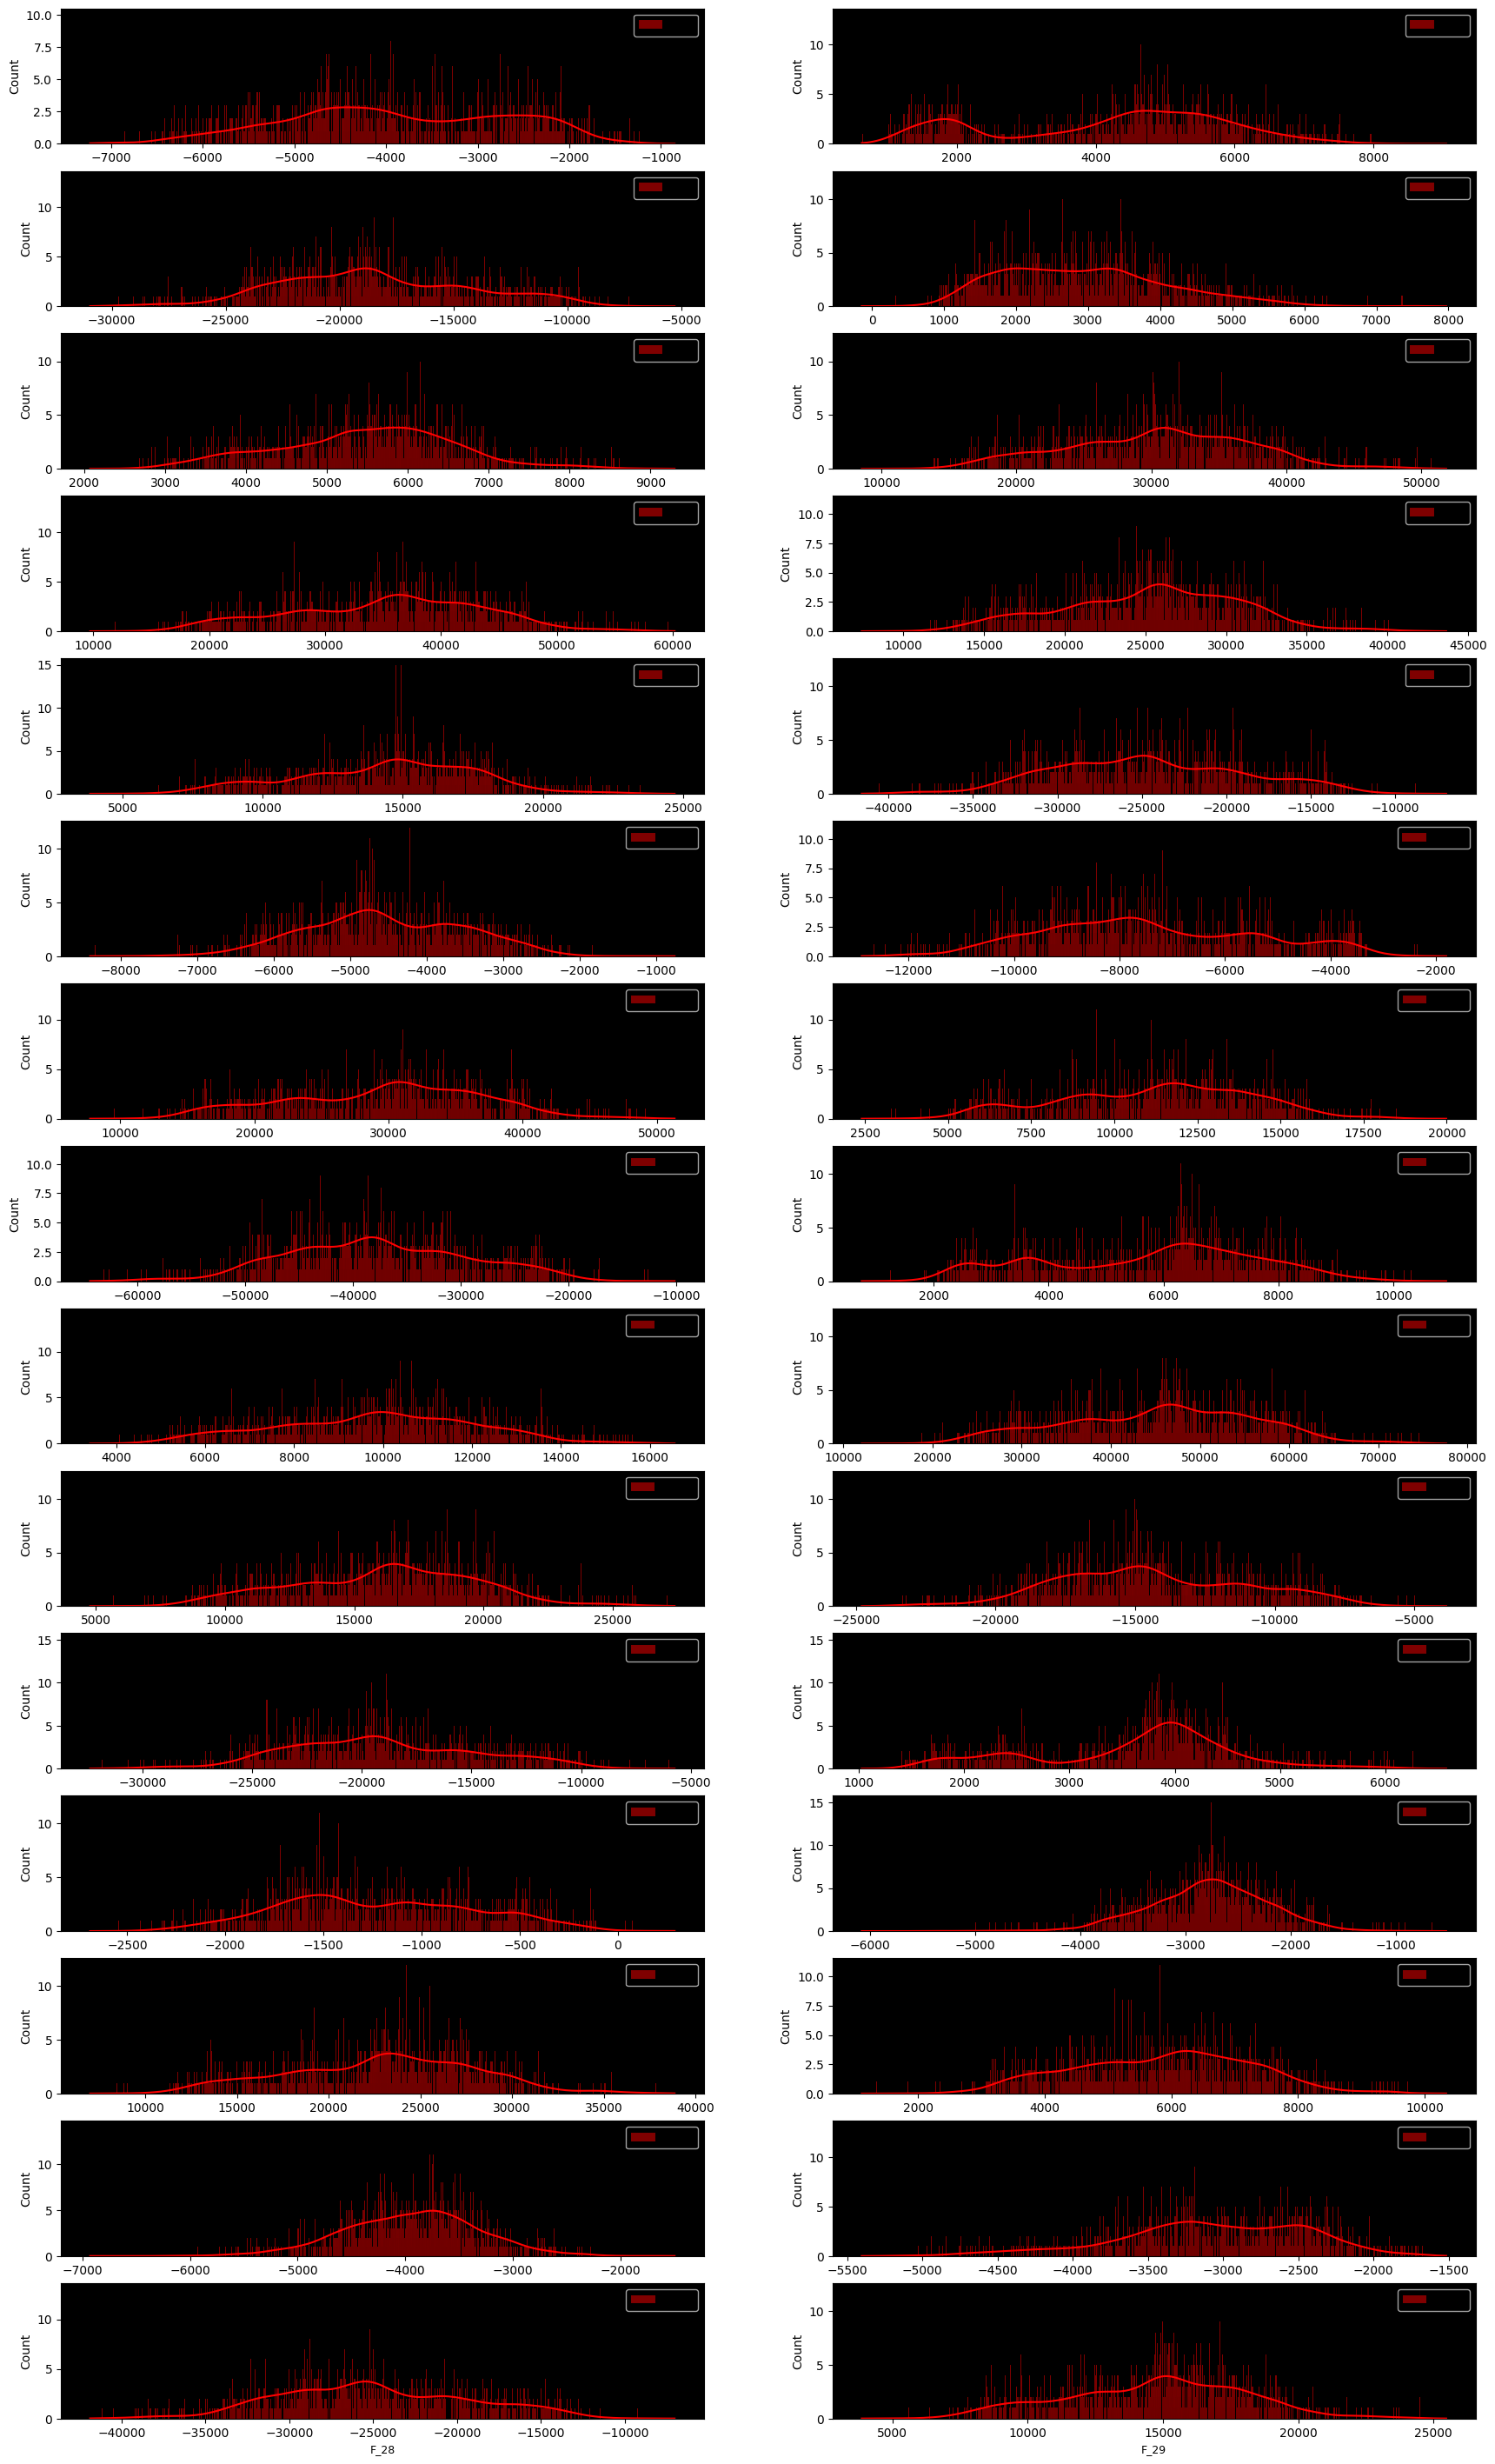

In [66]:
# cols = df.columns[1:]

# plt.figure()
# fig, ax = plt.subplots(15, 2 ,figsize=(21, 36))

# j = 1
# for col in cols[0:30]:
#     plt.subplot(15, 2, j)
#     sns.histplot(df[col], kde=True, bins=10000, label=col, color='Red')
#     plt.xlabel(col, fontsize=9); 
#     plt.rcParams['axes.facecolor'] = 'black'
#     plt.legend()
#     j += 1

# plt.show();

In [67]:
df.describe()

,Label,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_990,F_991,F_992,F_993,F_994,F_995,F_996,F_997,F_998,F_999
count,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,...,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000
mean,0.091888,-3880.457086,4221.956391,-18415.611561,2964.416305,5476.241779,30430.280913,35299.630835,25339.343484,14396.705727,...,29019.251525,-27693.796734,39296.610908,-26463.577269,26037.485545,-30737.393013,10550.054939,11411.088697,15721.631120,13.882746
std,0.288879,1213.625294,1670.577335,4225.348988,1170.373970,1097.393316,6769.936430,8383.790651,5522.253294,3208.358868,...,6948.355786,6511.504412,9315.188270,6105.823971,5830.096769,7384.926602,2952.538128,2414.029070,3415.849499,202.188364
min,0.000000,-7229.097700,627.832000,-30948.113000,-142.121670,2072.616000,8542.492000,9736.966000,7414.988000,3835.161000,...,7650.850600,-47587.824000,10660.444000,-45177.790000,7776.143000,-52763.004000,2657.584700,4150.162600,5384.082500,-834.587300
25%,0.000000,-4748.344700,2742.781700,-21492.083000,2038.876950,4749.318350,25664.323250,29022.553000,21504.816500,12174.833250,...,23896.758500,-32483.559000,32374.584500,-30965.541500,21883.566250,-36163.055000,8148.255000,9739.755000,13253.275750,-113.809859
50%,0.000000,-3974.510150,4580.385000,-18785.243000,2868.051500,5554.787000,30794.025500,36067.766000,25703.373500,14693.803500,...,29589.867500,-28250.630000,40057.480000,-26800.185500,26391.847500,-31148.503000,11023.349500,11583.415500,15943.856000,12.646134
75%,0.000000,-2844.764625,5464.797500,-15383.580250,3707.665500,6212.593975,35324.235000,41428.395000,29334.272750,16735.458750,...,34128.312750,-22820.796750,46092.680000,-22080.977750,30255.345000,-25245.420250,12747.735875,13018.571750,18169.259250,154.085958
max,1.000000,-850.746000,9047.459000,-5291.679000,7969.241000,9299.581000,51836.395000,60139.980000,43645.070000,24703.705000,...,49717.500000,-7990.443400,67941.230000,-7391.777300,44224.300000,-8010.190400,18629.904000,19314.174000,26196.814000,812.881960


In [68]:
min_list = []
max_list = []

for col in tqdm(cols):
    min_list.append(df[col].min())
    max_list.append(df[col].max())


100%|██████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 7566.20it/s]


<Figure size 640x480 with 0 Axes>

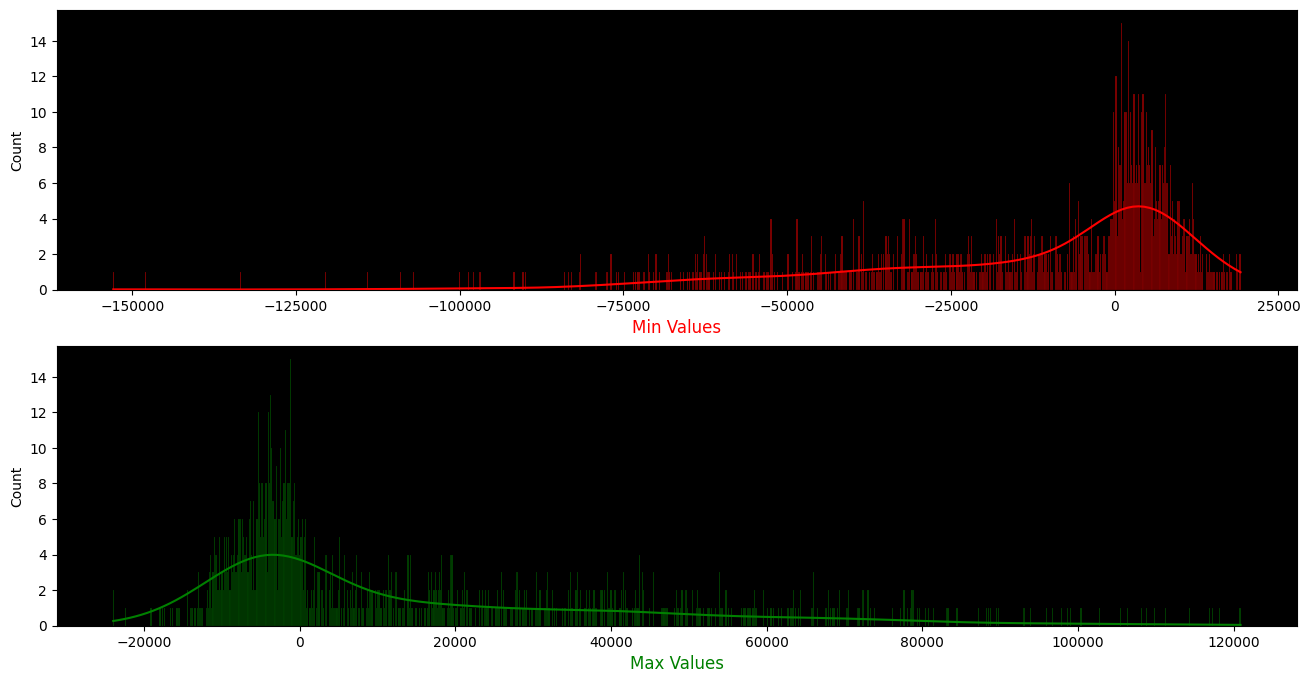

In [94]:
# plt.figure()
# fig, ax = plt.subplots(2, 1 ,figsize=(16, 8))

# for i in range(1, 3):
#     if i == 1:
#         plt.subplot(2, 1, i)
#         sns.histplot(min_list, kde=True,bins=1000, label="Features Min/Max Values Distribution", color='red')
#         plt.rcParams['axes.facecolor'] = 'black'
#         plt.xlabel("Min Values", fontsize=12, color='red')
# #         plt.legend()
        
#     elif i == 2:
#         plt.subplot(2, 1, i)
#         sns.histplot(max_list, kde=True,bins=1000, label="Features Min/Max Values Distribution", color='Green')
#         plt.rcParams['axes.facecolor'] = 'black'
#         plt.xlabel("Max Values", fontsize=12, color='Green')
# #         plt.legend()
    
#     else:
#         break;
        
# plt.show()

The First approach is going to be normalizing tha values of each column to be between -1,1

In [107]:
def ScaleMe(input_value, init_min, init_max, goal_min, goal_max):
    sclaled_value = ( ( (input_value - init_min) / (init_max - init_min) ) * (goal_max - goal_min) ) + goal_min
    
    return sclaled_value

#### A simple test ...
- Temp_vector = [1,2,3,4,5]
- Goal_vecor = [10,20,30,40,50]

In [132]:
# Temp_vector = [1,2,3,4,5] # --- > [10,20,30,40,50]
# Goal_vecor = []

# init_min = min(Temp_vector)
# init_max = max(Temp_vector)
# goal_min = 10
# goal_max = 50

# for idx in Temp_vector:
#     idx = ScaleMe(idx, init_min, init_max, goal_min, goal_max)
# #     Goal_vecor.append(int(Temp_var)) 

# print(Temp_vector)
    

[1, 2, 3, 4, 5]


OK, now we are going to apply it on each column of data frame seprately

In [224]:
init_min = df.iloc[:,1:].min()
init_max = df.iloc[:,1:].max()

goal_min = -1
goal_max = 1

# Apply the ScaleMe function to each column
scaled_df = pd.DataFrame()
for column in tqdm(df.iloc[:,1:].columns):
    df[column] = ScaleMe(df[column], init_min[column], init_max[column], goal_min, goal_max)

df

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.14it/s]


,Label,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_990,F_991,F_992,F_993,F_994,F_995,F_996,F_997,F_998,F_999
0,0.0,0.277372,-0.615168,0.224336,-0.445735,-0.269516,-0.171223,-0.222884,-0.178833,-0.181066,...,-0.204326,0.254114,-0.233859,0.179850,-0.196260,0.210875,-0.377951,-0.351414,-0.256950,0.378346
1,0.0,-0.130541,0.041848,-0.134103,-0.160929,-0.059789,0.131267,0.119419,0.103986,0.134152,...,0.142357,-0.099134,0.119599,-0.128862,0.110622,-0.137260,0.095425,0.045196,0.096342,0.105787
2,1.0,0.130408,-0.176096,0.041508,-0.355850,-0.148729,-0.069897,-0.072327,-0.091120,-0.041187,...,-0.078868,0.089545,-0.096484,0.097753,-0.084953,0.089393,-0.084663,-0.110564,-0.081895,0.274889
3,0.0,-0.048901,-0.011471,-0.063849,-0.270054,-0.102191,0.039532,0.048874,0.044312,0.086695,...,0.049213,-0.032999,0.041221,-0.053297,0.030051,-0.040106,0.042598,-0.019406,0.002123,0.267378
4,0.0,-0.484203,0.366222,-0.437459,0.014633,0.298974,0.420619,0.455462,0.376196,0.388797,...,0.465246,-0.438279,0.433525,-0.457899,0.410426,-0.490281,0.432583,0.282052,0.402785,0.039758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13827,0.0,-0.028082,-0.106008,-0.106702,-0.160814,0.058581,0.091861,0.095292,0.073248,0.085436,...,0.104352,-0.068842,0.077622,-0.073891,0.075323,-0.078415,0.060094,0.015908,0.073718,-0.350603
13828,0.0,-0.043126,0.183206,0.004159,-0.002382,-0.175601,0.004300,0.033599,-0.003198,-0.016766,...,0.043652,-0.002709,0.016395,-0.010907,0.002114,-0.048727,0.036789,-0.125225,-0.050151,0.306791
13829,0.0,-0.440252,0.093702,-0.261933,-0.404802,0.160788,0.199729,0.250910,0.195131,0.255778,...,0.244014,-0.235995,0.204007,-0.245006,0.203682,-0.245359,0.312797,0.083168,0.192885,0.176919
13830,0.0,0.483210,-0.208352,0.146442,-0.136143,-0.177333,-0.166753,-0.156148,-0.197578,-0.171186,...,-0.183973,0.175960,-0.161631,0.192254,-0.166952,0.181626,-0.148129,-0.098948,-0.181747,-0.214113


In [232]:
# df.describe()

,Label,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,...,F_990,F_991,F_992,F_993,F_994,F_995,F_996,F_997,F_998,F_999
count,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,...,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000,13832.000000
mean,0.091888,0.050002,-0.146251,-0.023052,-0.234028,-0.058076,0.011126,0.014331,-0.010526,0.012198,...,0.015931,0.004815,-0.000148,-0.009463,0.002045,-0.015677,-0.011731,-0.042348,-0.006613,0.030028
std,0.288879,0.380545,0.396829,0.329379,0.288576,0.303694,0.312743,0.332670,0.304844,0.307483,...,0.330350,0.328886,0.325247,0.323179,0.319912,0.330032,0.369707,0.318389,0.328246,0.245453
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,-0.222134,-0.497614,-0.262873,-0.462236,-0.259246,-0.209042,-0.234745,-0.222203,-0.200742,...,-0.227611,-0.237108,-0.241835,-0.247751,-0.225891,-0.258149,-0.312477,-0.262782,-0.243810,-0.124988
50%,0.000000,0.020511,-0.061110,-0.051866,-0.257789,-0.036339,0.027929,0.044811,0.009569,0.040671,...,0.043060,-0.023309,0.026419,-0.027280,0.021489,-0.034050,0.047533,-0.019619,0.014742,0.028527
75%,0.000000,0.374754,0.148974,0.213304,-0.050767,0.145703,0.237206,0.257521,0.210005,0.236339,...,0.258834,0.250943,0.237142,0.222506,0.233489,0.229759,0.263455,0.169665,0.228592,0.200233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now lets see what its looks like

In [225]:
# del min_list, max_list

In [229]:
# min_list = []
# max_list = []
# cols = df.columns[1:]

# for col in tqdm(cols):
#     min_list.append(df[col].min())
#     max_list.append(df[col].max())

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9613.22it/s]


<Figure size 640x480 with 0 Axes>

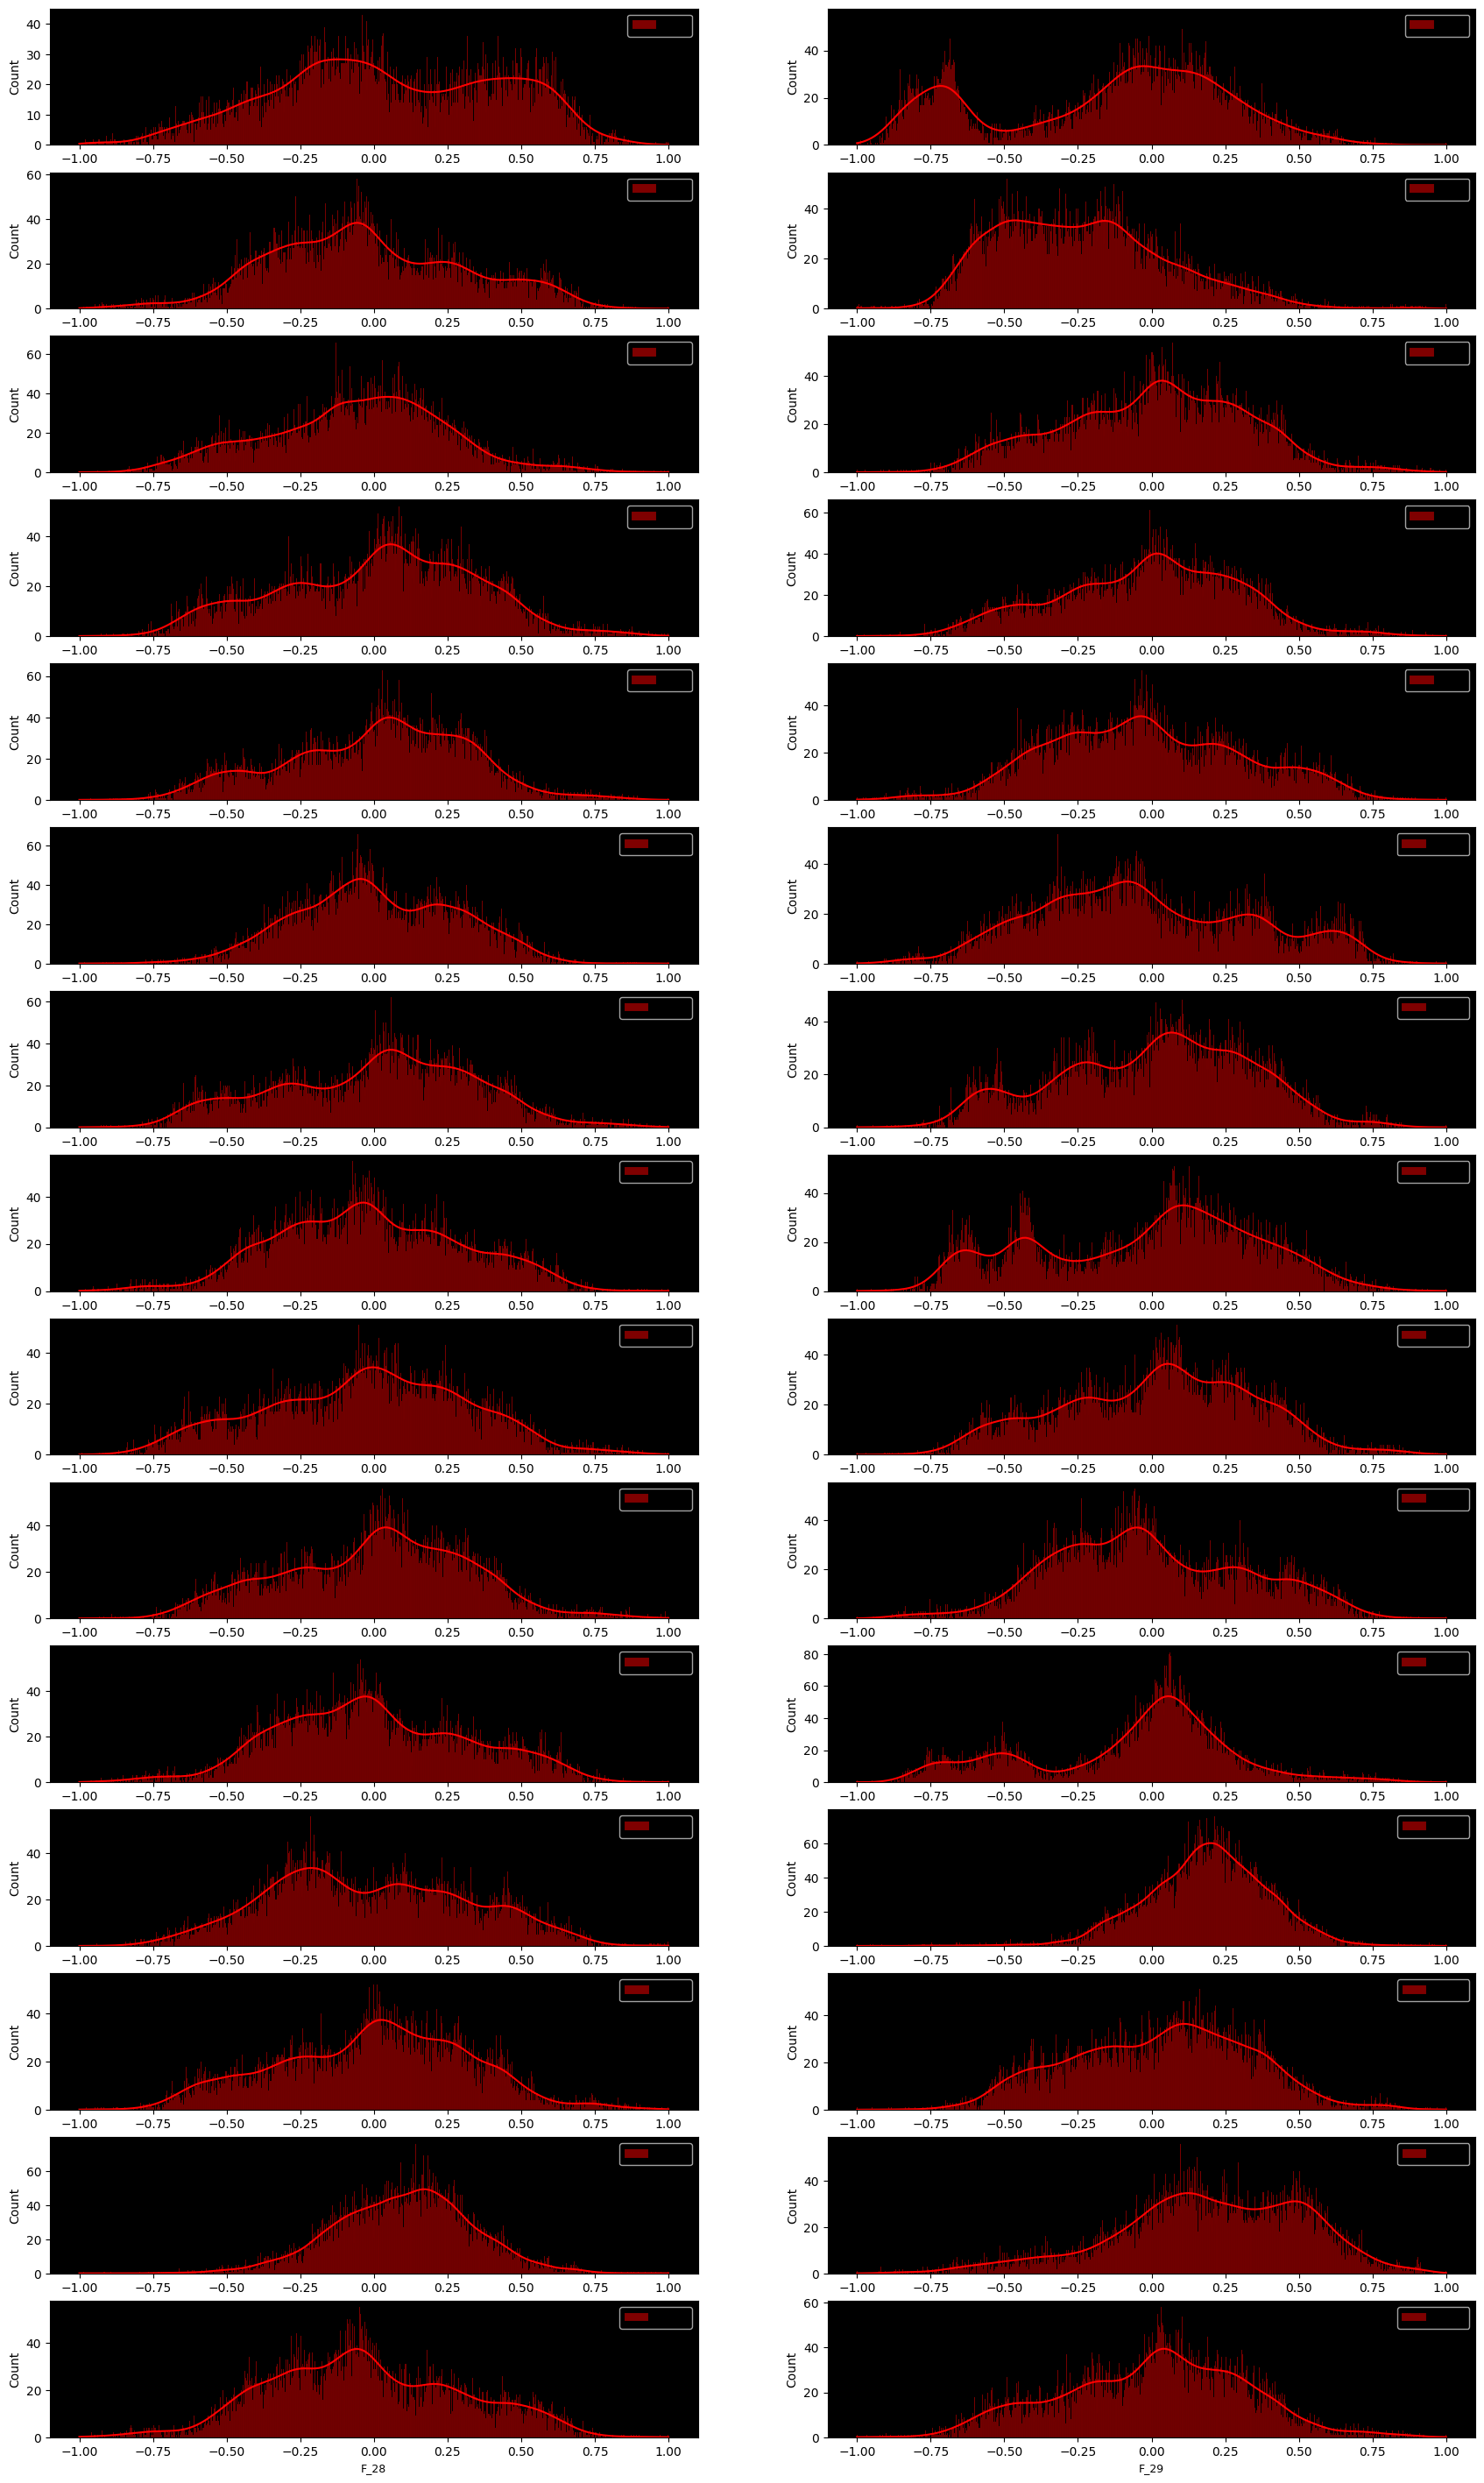

In [235]:
# cols = df.columns[1:]

# plt.figure()
# fig, ax = plt.subplots(15, 2 ,figsize=(21, 36))

# j = 1
# for col in cols[0:30]:
#     plt.subplot(15, 2, j)
#     sns.histplot(df[col], kde=True, bins=1000, label=col, color='Red')
#     plt.xlabel(col, fontsize=9); 
#     plt.rcParams['axes.facecolor'] = 'black'
#     plt.legend()
#     j += 1

# plt.show();

# Train Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df['Label'], test_size=0.2, random_state=42, stratify=df['Label'])

# Delete the residual
del df 
gc.collect()

0

In [4]:
# Load them as PyTorch Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [5]:
# Create DataLoader objects for batching the data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Define the Tabular Transformer module

In [16]:
class TabularTransformer(nn.Module):
    def __init__(
        self,
        input_dim,                   # Total number of Feature columns
        hidden_dim,                  # Neuron Density of MLP Layers
        output_dim,                  # Total number of Label columns
        num_attention_heads,         # Total Number of attention heads of Transformer
        num_transformer_layers,      # Total Number of transformer layers
        num_mlp_layers,              # Total number of MLP layers
        middle_activation,           # MLP layer Activation Function
        last_activation,             # Last layer Activation Function
        dropout_prob,                # Dropout possibility of Dropout layers (float)
        pooling_type                 # Pooling Strategy : mean(Average) , max(Maximum), global(mean)
    ):
        super(TabularTransformer, self).__init__()
        
        # New Line
        self.pooling_type = pooling_type
        
        
        """Should I remove this because of the situation with the data in the next steps"""
        # Embedding layer
        self.embedding = nn.Linear(1000, 128)
        
        # Transformer layers
        self.transformer = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model = hidden_dim,
                nhead = num_attention_heads,
            ),
            num_layers = num_transformer_layers
        )
        
        # MLP Layers
        self.mlp = nn.Sequential()
        for i in range(num_mlp_layers):
            # Last FC Layer
            if i == num_mlp_layers-1:
                self.mlp.add_module(
                    f"FC_{i+1}",
                    nn.Linear(hidden_dim, output_dim)
                )
                   
                
                ######## Suspicion Area ##########
            else:
                self.mlp.add_module(
                    f"FC_{i+1}",
                    nn.Linear(hidden_dim,hidden_dim)
                )    
                ######## Suspicion Area ##########
                
                
            # Activation Functions for Final FC Layer
            if i == num_mlp_layers-1:
                if last_activation == "sigmoid":
                    self.mlp.add_module(
                        f"Activation_{i+1}",
                        nn.Sigmoid()
                    )
                elif last_activation == "softmax":
                    self.mlp.add_module(
                        f"Activation_{i+1}",
                        nn.Softmax(dim=-1)
                    )
                else:
                    raise ValueError(f"Invalid activation function for the last layer: {last_activation}")
            
            # Activation Functions for other FC layers
            else:
                if middle_activation == "relu":
                    self.mlp.add_module(
                        f"Activation_{i+1}",
                        nn.ReLU()
                    )
                elif middle_activation == "leakyrelu":
                    self.mlp.add_module(
                        f"Activation_{i+1}",
                        nn.LeakyReLU()
                    )
                else:
                    raise ValueError(f"Invalid activation function for the middle layers : {last_activation} ")
            
            # Dropout Layer
            if i != num_mlp_layers-1:
                if dropout_prob > 0.0:
                    self.mlp.add_module(
                        f"Dropout_{i+1}",
                        nn.Dropout(dropout_prob)
                    )
       
                    
    def forward(self, x, memory=None): 
        # Apply linear transformation
        embedded = self.embedding(x)
        
        print(f" This is embeded before long:\n {embedded}")
        embedded = self.embedding.weight[embedded.long(), :].to_dense()
        print(f" This is embeded after long:\n {embedded}")
        embedded = embedded.permute(2, 0, 1)       
        memory = torch.rand(1000, 1, 128)
        
        transformer_output = self.transformer(embedded, memory)
    
#         # Reset the dimensions to original order for upcoming FC/Pooling Layers
#         transformer_output = transformer_output.permute(1, 0, 2)
        transformer_output = transformer_output.permute(2, 0, 1)
        
        # Pooling Layer
        if self.pooling_type == "mean":
#             pooled_output = F.avg_pool1d(transformer_output, kernel_size=transformer_output.size(1)).squeeze(2)
            pooled_output = torch.mean(transformer_output, dim=1)

        elif self.pooling_type == "max":
#             pooled_output = F.max_pool1d(transformer_output, kernel_size=transformer_output.size(1)).squeeze(2)
            pooled_output = torch.max(transformer_output, dim=1) 

        else:
            raise ValueError(f"Invalid pooling_type: {self.pooling_type}")
        
        pooled_output = pooled_output.permute(1,0)
        print(pooled_output.shape)
        mlp_output = self.mlp(pooled_output) 
        
        return mlp_output
                    

# Model Instantiation

In [17]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [18]:
model = TabularTransformer(
    input_dim = 1000,
    hidden_dim = 128,
    output_dim = 1,
    num_attention_heads = 4,
    num_transformer_layers = 1,
    num_mlp_layers = 4,
    middle_activation = 'relu',
    last_activation = 'sigmoid',
    dropout_prob = 0.1,
    pooling_type = 'mean'

).to(device)


In [19]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [96]:
# A simple test
temp = torch.rand(1, 1000, dtype=torch.float32)
model(temp)

 This is embeded before long:
 tensor([[ 0.6037, -0.3759, -0.4482, -0.4484,  0.3146, -0.3315,  0.2043,  0.1817,
          0.0590,  0.2244,  0.4269, -0.3765,  0.2151,  0.0179, -0.0925,  0.2535,
          0.1801,  0.1389,  0.4834,  0.7438,  0.0442,  0.0316,  0.2288,  0.3606,
          0.1639, -0.4441,  0.3568,  0.3033,  0.1854,  0.2598, -0.5340,  0.1113,
          0.2492, -0.1948,  0.1298, -0.5931,  0.3347, -0.3338,  0.5093,  0.0231,
         -0.1270, -0.0636, -0.4088,  0.5384,  0.1858, -0.4082, -0.5406, -0.3945,
          0.3480,  0.0678,  0.4606,  0.5904,  0.0374, -0.4829, -0.1449,  0.3049,
         -0.3159,  0.0031,  0.2145, -0.3102,  0.4850,  0.0019, -0.1506,  0.1282,
         -0.3403,  0.3663, -0.0085, -0.1196, -0.4619, -0.0846,  0.1419,  0.3450,
          0.0141, -0.3507, -0.7004, -0.2056,  0.7040,  0.2090,  0.2135, -0.3378,
          0.1992, -0.3157,  0.2111, -0.1822, -0.0471, -0.0897, -0.5047,  0.0931,
          0.3176, -0.0634, -0.1589, -0.2434,  0.0792,  0.0025, -0.0407,  0.399

tensor([[0.5116]], grad_fn=<SigmoidBackward0>)

In [11]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [21]:
num_epochs = 50
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    TP = 0
    FN = 0
    FP = 0
    
    for inputs, labels in train_loader:
        # All set to work on same device
        inputs = inputs
        labels = labels
        # Reset the Gradients
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backpropagate
        loss.backward()
        
        # Update the weights and loss
        optimizer.step()
        running_loss += loss.item()
        
    # Metric Calculations
    if TP == 0 and FN == 0:  # (Recall is 0/0)
        recall = 0.0
        precision = 0.0
        f1_score = 0.0
        
    elif TP == 0 and FP == 0:  # (Precision is 0/0)
        recall = 0.0
        precision = 0.0
        f1_score = 0.0
    
    else:
        recall = TP/(TP+FN)
        precision = TP/(TP+FP)
        f1_score = (2*precision*recall)/(precision+recall)
        
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1_score:.4f}")
        

 This is embeded before long:
 tensor([[ 11513.6875,  13335.2939,   4413.0874, -18137.8027,   6702.6357,
          -4060.3420, -16316.0498,   2769.1111,  11114.1875,   -945.0446,
           5198.6680, -26096.1465, -12614.7627,  -4358.4487,  -5658.6787,
          -4883.2021,   3789.2939, -11778.5391,  -4773.1289,    114.2630,
         -25200.1172,  -8314.9434,  -7983.5112,  -1421.2728, -23518.0234,
           1184.0432, -17158.9141,  -5894.2515, -13690.9805,  -6095.0083,
          21436.1777,  15581.5029, -21220.6641,   1043.3541,    354.7627,
          15113.4199,  10080.5557,  15378.0557,  -6473.1108, -10588.1953,
          -2888.7969,  -8467.5625,   8892.6504,  -4051.4529,   7754.0488,
          18770.9473,   -904.8625, -19507.9082, -19370.8203,  34262.8711,
          11321.2861, -36502.7656,   7888.3242, -13429.7539, -16514.5410,
          -2502.9729,   5846.9966,  -3028.6243,   3060.8579,  11900.7158,
          16379.3877,   5454.4893,   6008.8213,  -1432.8927,   4806.9189,
       

IndexError: index -18739 is out of bounds for dimension 0 with size 128